In [2]:
    
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
    

In [3]:
# turnout data
turnout_data_path = 'data/iowa_counties_turnout.json'
cities_data_path = 'data/iowa_cities_clean.json'
shapes_data_path = 'data/shapefiles/iowa counties/cleaned_counties.shp'

df_turnout = pd.read_json(turnout_data_path)
print(df_turnout.head())

df_cities = pd.read_json(cities_data_path)
print(df_cities.head())
 # todo match the decimal point convention on the shape file lat/long coordinates

# map - county shapes data 

shapes = gp.GeoDataFrame.from_file(shapes_data_path)
identifier_column = 'COUNTY' # name of column where you can find county names
print(shapes.head())



       %  BallotsCast     County  TotalVoters
0  65.24         3459      Adair         5302
1  60.55         1768      Adams         2920
2  57.14         5712  Allamakee         9996
3  57.28         5073  Appanoose         8856
4  63.03         2719    Audubon         4314
           City    County        DataFreshness  Estimate     FIPS   Latitude  \
0    Des Moines      Polk  2017-07-01T00:00:00    217295  1921000  41.591064   
1  Cedar Rapids      Linn  2017-07-01T00:00:00    132228  1912000  41.975887   
2     Davenport     Scott  2017-07-01T00:00:00    102320  1919000  41.523644   
3    Sioux City  Woodbury  2017-07-01T00:00:00     82508  1973335  42.496682   
4     Iowa City   Johnson  2017-07-01T00:00:00     75798  1938595  41.661256   

   Longitude  
0 -93.603715  
1 -91.670405  
2 -90.577637  
3 -96.405878  
4 -91.529911  
           AREA  PERIMETER  COUNTY_  COUNTY_ID  CO_NUMBER  CO_FIPS  ACRES_SF  \
0  1.523795e+09   193975.5        2          1         60      119  37653

Text(0.5,1,'test cities superposition')

<Figure size 432x288 with 0 Axes>

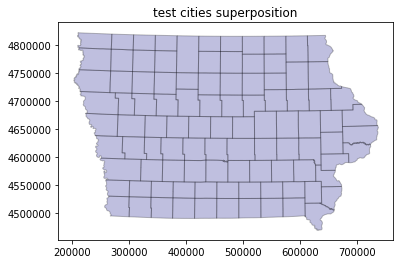

In [4]:
# try plot the cities
plt.figure()
fig, ax = plt.subplots()

#plt.plot(p_x1, p_y1,'x',color='r') # testing
#plt.plot(p_x2, p_y2,'x',color='g')
#plt.plot(p_x3, p_y3,'x',color='b')

#MAP_UNIT_CONVERSION = (200000,-50000)
#for idx, city in df_cities.iterrows():
#    city_name = city['City']
#    x = city['Latitude']*MAP_UNIT_CONVERSION[0] - 1950000
#    y = city['Longitude']*MAP_UNIT_CONVERSION[1] # unit convention
#    plt.plot(x,y,'x',alpha=0.5,linewidth=1)

for idx, row in shapes.iterrows():
    county_name = shapes.loc[idx,'COUNTY']
    shapes.loc[[idx],'geometry'].plot(ax=ax,alpha=0.25,linewidth=1,edgecolor='black',facecolor='navy') # plot_color)

#for idx in range(shapes.shape[0]): # counties
#    county_name = shapes.loc[idx,identifier_column]
#    shapes.loc[[idx],'geometry'].plot(ax=ax, alpha=1, linewidth=0, edgecolor='black',facecolor=plot_color)
#plot.axis('off')
plt.title('test cities superposition')




<Figure size 432x288 with 0 Axes>

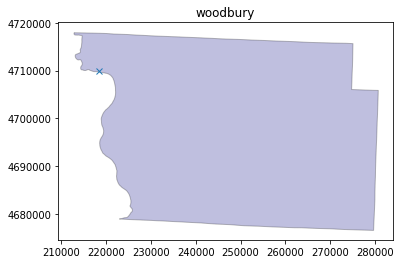

<Figure size 432x288 with 0 Axes>

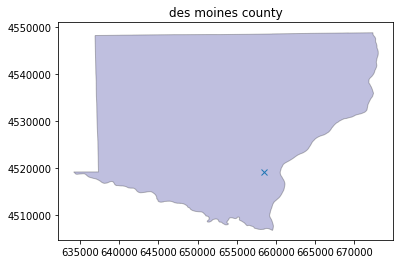

In [16]:
# calibrate a map 2 longlat mapping using reference points

# plot Woodbury county (Sioux City)
plt.figure()
fig, ax = plt.subplots()
W = shapes.loc[ shapes['COUNTY']=='Woodbury' ].plot(ax=ax,alpha=0.25,linewidth=1,edgecolor='black',facecolor='navy')
SC_map = (218500,4710000) # hand inspected location of sioux city (NW reference point)
plt.plot(SC_map[0],SC_map[1],'x')
plt.title('woodbury')
plt.show()

# plot Des Moines County (Burlington?)
plt.figure()
fig, ax = plt.subplots()
DMC = shapes.loc[ shapes['COUNTY']=='Des Moines' ].plot(ax=ax,alpha=0.25,linewidth=1,edgecolor='black',facecolor='navy')
B_map = (658500,4519000) # hand inspected location of burlington (SE reference point)
plt.plot(B_map[0],B_map[1],'x')
plt.title('des moines county')
plt.show()

# do interactive plot

In [17]:
# algebra for solving coefficients for the linear scaling on each map dimension:

W = df_cities.loc[ df_cities['City']=='Sioux City'] # woodburty county
DMC = df_cities.loc[ df_cities['City']=='Burlington'] # Des moines county

W_xy = (float(W['Longitude']), float(W['Latitude']))
DMC_xy = (float(DMC['Longitude']), float(DMC['Latitude']))

#SC_map
#B_map
#CR_map = (550000,4705000) # whoops this in't CR

m_x = (SC_map[0] - B_map[0]) / (W_xy[0] - DMC_xy[0])
b_x = B_map[0] - m_x*DMC_xy[0]
print(m_x,b_x)

m_y = (SC_map[1] - B_map[1]) / (W_xy[1] - DMC_xy[1])
b_y = B_map[1] - m_y*DMC_xy[1]
print(m_y, b_y)

print(W_xy, DMC_xy)
print(SC_map, B_map)

def map2longlat(map_x, map_y): # long lat instead of lat-long, to match the x,y ordering convention
    long = (map_x - b_x) / m_x
    lat = (map_y - b_y) / m_y
    return (long,lat)

def longlat2map(long, lat):
    map_x = m_x * long + b_x
    map_y = m_y * lat + b_y
    return (map_x, map_y)


83129.37038495013 8232659.95617419
113075.13209069871 -95317.87402885221
(-96.4058782, 42.4966815) (-91.1129234, 40.8075391)
(218500, 4710000) (658500, 4519000)


In [ ]:
# try plot the cities
import math

plt.figure()
fig, ax = plt.subplots()

def pop2radius(population): # scale area with population
    scalar = 30
    radius = math.sqrt( 2*population/math.pi ) # from the equation for area of a circle
    return radius*scalar

for idx, row in shapes.iterrows():
    county_name = shapes.loc[idx,'COUNTY']
    shapes.loc[[idx],'geometry'].plot(ax=ax,alpha=0.25,linewidth=1,edgecolor='black',facecolor='navy') # plot_color)

for idx, city in df_cities.iterrows():
    city_name = city['City']
    population = city['Estimate']
    r = pop2radius(population)
    (x,y) = longlat2map(city['Longitude'],city['Latitude'])
    #plt.plot(x,y,'x',alpha=0.5,linewidth=1)
    ax.add_patch(plt.Circle((x,y),r,color='#111111',alpha=0.25))


plt.title('test cities superposition')

In [ ]:
# add fields to dataframe

map_x = []
map_y = []
for idx,city in df_cities.iterrows():
    #print(city['City'])
    (x,y) = longlat2map(city['Longitude'],city['Latitude'])
    map_x.append(x)
    map_y.append(y)

df_cities['MapX'] = map_x
df_cities['MapY'] = map_y

In [ ]:
city_file_target = 'data/iowa_cities_registered.json'
df_cities.to_json(orient='records',path_or_buf = city_file_target)